In [9]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 149kB/s 
     |████████████████████████████████| 2.3MB 36.0MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [0]:
import numpy as np
import os
import random
import tensorflow as tf
from collections import Counter
import csv

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional,TimeDistributed

In [0]:
batch_size = 16 #32, 64
epochs = 100
latent_dim = 256
num_samples = 5000
data_path = '/content/jeju_final.txt'

In [0]:
input_texts = [] # 제주어
target_texts = [] # 표준어

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples, len(lines)-1)]:
    input_text, target_text = line.split('\t')
    target_text = target_text.strip() # 타겟 데이터 앞뒤 구분자는 뒤어서 넣어주자
    input_texts.append(input_text)
    target_texts.append(target_text)

In [0]:
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Hannanum
from konlpy.tag import Mecab
from konlpy.tag import Okt
import json
import os
from pprint import pprint

In [0]:
def make_morph_to_json(dataset, json_path, package='Okt'):
    if package == 'Kkma':
        tokenizer = Kkma()
    elif package == 'Komoran':
        tokenizer = Komoran()
    elif package == 'Hannanum':
        tokenizer = Hannanum()
    elif package == 'Mecab':
        tokenizer = Mecab()
    else:
        tokenizer = Okt()
    tokenized = [tokenizer.morphs(row) for row in dataset]
    length = []
    for tok in tokenized:
        length.append(len(tok))
    max_token_length = max(length)
    
    with open(json_path, 'w', encoding='utf-8') as make_file:
        json.dump(tokenized, make_file, ensure_ascii=False, indent='\t')
    return max_token_length

#make_morph_to_json(target_texts, 'mecab_seoul.json', Mecab)


In [0]:
# 사용자 정의 사전 okt -> komoran으로 맵핑
with open('/content/jeju_vocab.txt', encoding='utf-8-sig') as f:
    fn = open('/content/jeju_dic.txt', 'w')
    for line in f:
        dic, pos = line.split('\t')
        pos = pos.lower().strip()
        if pos in 'noun':
            pos = 'NN'
        elif pos in 'verb':
            pos = 'VV'
        elif pos in 'adverb' or pos in 'adberb':
            pos = 'MA'
        elif pos in 'determiner':
            pos = 'NP'
        elif pos in 'exclamation':
            pos = 'IC'
        elif pos in 'adjective':
            pos = 'VA'
        elif pos in 'suffix':
            pos = 'XS'
        elif pos in 'josa':
            pos = 'JK'
        elif pos in 'number':
            pos = 'SN'
        else:
            pass
        new_line = dic + '\t' + pos + '\n'
        fn.write(new_line)
    fn.close()

In [0]:
# 사용자 정의 사전 적용해서 형태소 분석 (Komoran)
jeju_dic = '/content/jeju_dic.txt'
komoran = Komoran(userdic='/content/jeju_dic.txt')
tokenized = [komoran.morphs(row) for row in input_texts]
token_length = []
for token in tokenized:
    token_length.append(len(token))
max_token_length = max(token_length)
with open('jeju_userdic.json', 'w', encoding='utf-8') as make_file:
   json.dump(tokenized, make_file, ensure_ascii=False, indent='\t')



In [0]:
# json 불러와서 딕셔너리 만들기
def make_dictionary_morph(json_path):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
        morph_dictionary = set()
        for sentence in json_data:
            for morph in sentence:
                if morph not in morph_dictionary:
                    morph_dictionary.add(morph)
        morph_dictionary = sorted(list(morph_dictionary))
    return morph_dictionary, json_data

#morph_dictionary, kkma_morphs = make_dictionary_morph(json_path)
#target_to_index, target_reverse_index, len_target_tokens = make_token_index(morph_dictionary)
#morph_dictionary, json_data = make_dictionary_morph('jeju_userdic.json')

In [0]:
# 토큰 인덱스
def make_token_index(dictionary):
    to_index = [(char, i) for i, char in enumerate(dictionary)]
    to_index.append(('<unk>', len(to_index)))
    to_index.append((' ', len(to_index)))
    to_index = dict(to_index)
    reverse_index = [(i, char) for i, char in enumerate(dictionary)]
    reverse_index.append((len(reverse_index), '<unk>'))
    reverse_index.append((len(reverse_index), ' '))
    reverse_index = dict(reverse_index)
    return to_index, reverse_index, len(to_index)

#make_token_index(make_dictionary_char(input_texts))
#make_token_index(morph_dictionary)

In [0]:
# 테스트를 해봅시다
# 코모란으로, 타겟(표준어)은 걍 돌리고 제주어는 사용자 정의한 걸로

input_path = '/content/jeju_userdic.json'
target_path = '/content/seoul_Komoran.json'
max_encoder_length = max_token_length
max_decoder_length = make_morph_to_json(target_texts, target_path, package='Komoran')

In [0]:
input_morph_dic, input_morph_data = make_dictionary_morph(input_path)
target_morph_dic, target_morph_data = make_dictionary_morph(target_path)

input_index, input_reverse_index, num_encoder_tokens = make_token_index(input_morph_dic)
target_index, target_reverse_index, num_decoder_tokens = make_token_index(target_morph_dic)

In [0]:
# 필요한 건, 총 데이터 길이 / 문장 길이 / 토큰 길이
# 원핫인코딩 ㅠㅠ 밖에 못헤ㅐㅇ잉 ㅠㅠㅠ 임베딩은 ... 추후 과제....ㅎ

encoder_input_data = np.zeros((len(input_texts), max_encoder_length, num_encoder_tokens),
                             dtype='float32')
decoder_input_data = np.zeros((len(target_texts), max_decoder_length, num_decoder_tokens),
                             dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_length, num_decoder_tokens),
                              dtype='float32')

for i, sentence in enumerate(input_morph_data):
    for j, token in enumerate(sentence):
        encoder_input_data[i, j, input_index[token]] = 1.
    encoder_input_data[i, j+1:, input_index[' ']] = 1.
for i, sentence in enumerate(target_morph_data):
    for j, token in enumerate(sentence):
        decoder_input_data[i, j, target_index[token]] = 1.
        if j > 0:
            decoder_target_data[i, j-1, target_index[token]] = 1.
    decoder_input_data[i, j+1:, target_index[' ']] = 1.
    decoder_target_data[i, j:, target_index[' ']] = 1.


In [13]:
print(decoder_input_data.shape)
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(466, 20, 716)
(466, 28, 708)
(466, 20, 716)


In [0]:
# encoder = TimeDistributed(Dense(latent_dim, activation="relu"))
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim,dropout=0.25, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


In [0]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim,dropout=0.25, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [32]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
         batch_size = batch_size, epochs=epochs, validation_split=0.2)
model.save_weights('k_s2s.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 372 samples, validate on 94 samples
Epoch 1/100





372/372 [==============================] - 5s 14ms/step - loss: 1.5780 - acc: 0.8480 - val_loss: 2.6502 - val_acc: 0.6771
Epoch 2/100
372/372 [==============================] - 2s 6ms/step - loss: 0.8187 - acc: 0.8887 - val_loss: 2.6147 - val_acc: 0.6771
Epoch 3/100
372/372 [==============================] - 2s 6ms/step - loss: 0.7884 - acc: 0.8887 - val_loss: 2.9954 - val_acc: 0.6771
Epoch 4/100
372/372 [==============================] - 2s 6ms/step - loss: 0.7738 - acc: 0.8887 - val_loss: 2.6783 - val_acc: 0.6771
Epoch 5/100
372/372 [==============================] - 2s 6ms/step - loss: 0.7654 - acc: 0.8866 - val_loss: 3.2586 - val_acc: 0.6771
Epoch 6/100
372/372 [==============================] - 2s 6ms/step - loss: 0.7351 - acc: 0.8887 - val_loss: 2.7140 - val_acc: 0.6771
Epoch 7/100
372/372 [==============================]

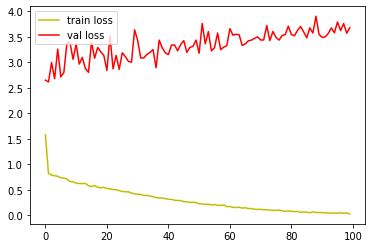

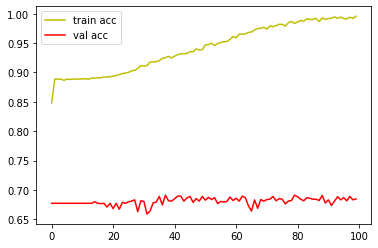

In [33]:
 import matplotlib.pyplot as plt
  # 손실 그래프
plt.plot(model.history.history['loss'], 'y', label='train loss')
plt.plot(model.history.history['val_loss'], 'r', label='val loss')
plt.legend(loc='upper left')
plt.show()

# 정확도 그래프
plt.plot(model.history.history['acc'], 'y', label='train acc')
plt.plot(model.history.history['val_acc'], 'r', label='val acc')
plt.legend(loc='upper left')
plt.show()